In [2]:
# rm(list=ls())
getwd()
dir='/Users/sungjinpark/OneDrive - konkuk.ac.kr/datamining/appstore_2/1preprocessing'
setwd(dir)
#install.packages('ggplot2')
# install.packages('scales')
# install.packages('dplyr')
# install.packages('stringr')
# install.packages('tidyr')
# install.packages('nnet')
# install.packages('randomForest')
# install.packages('e1071')
# install.packages('mcca')
library(ggplot2)#시각화
library(scales) #시각화
library(dplyr) # 전처리
library(stringr)
library(tidyr)
library(nnet) # multinom
library(randomForest)#rf
library(e1071)
library(mcca) # measure

[1] "/Users/sungjinpark/OneDrive - konkuk.ac.kr/datamining/appstore_2/1preprocessing"

In [3]:
load('game_nongame.rda')
load('game_etc.rda')

## 1. data preprocessing to get quantile

In [4]:
#size : byte -> megabyte
new_data1['size_mega'] = new_data1['size_bytes'] / (1024 * 1024.0)
new_data2['size_mega'] = new_data2['size_bytes'] / (1024 * 1024.0)
drops <- c("size_bytes")
new_data1=new_data1[ , !(names(new_data1) %in% drops)]
new_data2=new_data2[ , !(names(new_data2) %in% drops)]
#min(new_data1$size_mega)
#max(new_data1$size_mega)
new_data1$sum_rate_ver = new_data1$rating_count_ver*new_data1$user_rating_ver
new_data2$sum_rate_ver = new_data2$rating_count_ver*new_data2$user_rating_ver
reg_data_1 = new_data1 # game vs nongame
reg_data_2 = new_data2 # game,... and etc
reg_data_1$user_rating_scaled <- scale(new_data1$user_rating)[, 1]
reg_data_2$user_rating_scaled <-scale(new_data2$user_rating)[, 1]

quantile(reg_data_1$user_rating_scaled)
quantile(new_data1$user_rating)

0%         25%         50%         75%        100% 
-2.32111659 -0.01730498  0.31181096  0.64092691  0.97004285

0%  25%  50%  75% 100% 
 0.0  3.5  4.0  4.5  5.0

## 2. select user_rating_scaled's quantile

In [5]:
# using reg_data_1 -> quantile
quan_1<- reg_data_1 %>% mutate(user_rating_cls=cut(user_rating_scaled, breaks=c(-Inf, -0.01775798, 0.64102630, Inf), labels=c("low","middle","high")))
quan_2<- reg_data_2 %>% mutate(user_rating_cls=cut(user_rating_scaled, breaks=c(-Inf, -0.01775798, 0.64102630, Inf), labels=c("low","middle","high")))
drops<-c("user_rating","user_rating_scaled")
quan_1=quan_1[ , !(names(quan_1) %in% drops)]
quan_2=quan_2[ , !(names(quan_2) %in% drops)]
levels(quan_1$user_rating_cls)
levels(quan_2$user_rating_cls)

[1] "low"    "middle" "high"

[1] "low"    "middle" "high"

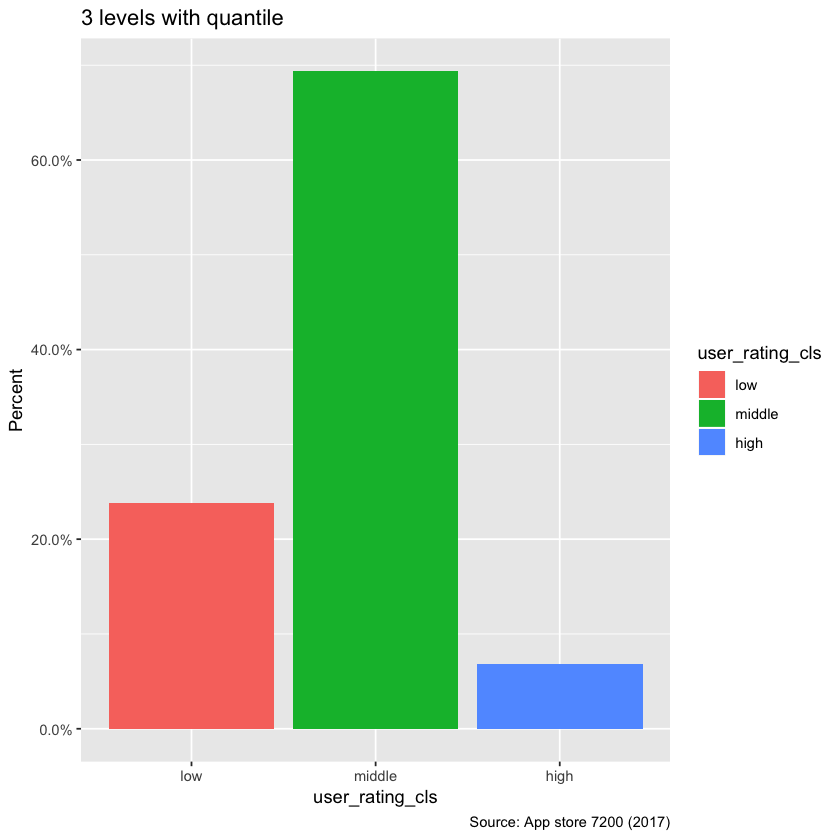

In [6]:
ggplot(quan_1, aes(x = factor(user_rating_cls),
                  fill = factor(user_rating_cls))) +
  geom_bar(aes(y = (..count..)/sum(..count..))) + 
  scale_y_continuous(labels=percent_format()) +
  labs(title="3 levels with quantile", 
       
       caption="Source: App store 7200 (2017)",
       x="user_rating_cls",y = 'Percent',
       fill="user_rating_cls")

# 3. train_test split

In [7]:
#############################################
train_index <- sample(1:nrow(new_data1), 0.8 * nrow(new_data1))
test_index <- setdiff(1:nrow(new_data1), train_index)
# Build train/test
quan_1_train <- quan_1[train_index,]
quan_1_test <- quan_1[test_index,]
quan_2_train <- quan_2[train_index,]
quan_2_test <- quan_2[test_index,]

# 4. modeling with deult parameters

- mutinomial/ svm with various kernels 
- measuer with ccp(acc)/hum
- [What is ccp and hum ?](https://cran.r-project.org/web/packages/mcca/mcca.pdf)

In [8]:
result.mat =matrix(0,2,2)
colnames(result.mat) = c("multinom",'rf')
rownames(result.mat) = c("test_acc","test_hum");result.mat

,multinom,rf
test_acc,0,0
test_hum,0,0


In [9]:
# get ccp : 
get_ccp = function(model,data){
  label = data$user_rating_cls
  ptr=as.numeric(predict(model,newdata=data[,-13]))
  out_ccp = ccp(y=label, d = ptr, method='label',k=3)
  return(out_ccp)
}

set.seed(1)
multinom_1.fit = multinom(user_rating_cls~.,data=quan_1_train)
multinom.ccp.te = get_ccp(multinom_1.fit,quan_1_test);multinom.ccp.te
set.seed(1)
predict.probs <- predict(multinom_1.fit, type = "probs",newdata=quan_1_test);predict.probs
pp<- data.frame(predict.probs)
label = as.numeric(quan_1_test[,13])
multinom.hum.te=hum(y = label, d = pp, method = "prob", k = 3);multinom.hum.te

result.mat[,1] = c(multinom.ccp.te,multinom.hum.te)
result.mat


set.seed(1)
rf_1.fit =randomForest(user_rating_cls~.,data=quan_1_train,type='C')
rf.ccp.te = get_ccp(rf_1.fit,quan_1_test);rf.ccp.te

set.seed(1)
predict.probs <- predict(rf_1.fit, type = "prob",newdata=quan_1_test);predict.probs
pp<- data.frame(predict.probs)
label = as.numeric(quan_1_test[,13])
rf.hum.te=hum(y = label, d = pp, method = "prob", k = 3);rf.hum.te

# weights:  48 (30 variable)
initial  value 6301.640088 
iter  10 value 4745.800808
iter  20 value 3948.847778
iter  30 value 3134.280743
iter  40 value 2891.405103
iter  50 value 2870.837242
iter  60 value 2853.217478
final  value 2853.180081 
converged


[1] 0.8040446

,low,middle,high
14,1.486434e-10,0.9822364,1.776356e-02
17,1.873312e-01,0.7437183,6.895048e-02
18,2.084265e-16,0.9970257,2.974275e-03
22,1.317134e-06,0.8560556,1.439431e-01
23,2.548381e-02,0.8741651,1.003511e-01
30,3.745257e-02,0.8897476,7.279979e-02
40,3.249672e-01,0.5911186,8.391426e-02
43,7.862153e-01,0.2101580,3.626640e-03
50,2.909974e-02,0.8678023,1.030980e-01
63,1.655019e-01,0.8007695,3.372854e-02


[1] 0.6011467

,multinom,rf
test_acc,0.8040446,0
test_hum,0.6011467,0


[1] 0.8668061

,low,middle,high
14,0.056,0.800,0.144
17,0.204,0.786,0.010
18,0.012,0.956,0.032
22,0.008,0.746,0.246
23,0.060,0.900,0.040
30,0.084,0.880,0.036
40,0.228,0.724,0.048
43,0.228,0.746,0.026
50,0.024,0.890,0.086
63,0.312,0.686,0.002


[1] 0.7892026

## Default model result

In [10]:
result.mat[,2] = c(rf.ccp.te,rf.hum.te)
result.mat

,multinom,rf
test_acc,0.8040446,0.8668061
test_hum,0.6011467,0.7892026


# 5.1 Tuning - RF

- RF tune on mtry, ntree, nodesize



In [11]:
# Tuning
#############################################
tune_mat = matrix(0,4,6)
colnames(tune_mat) = c("default","mtry:3","mtry:5","mtry:7","mtry9","mtry:11")
rownames(tune_mat) = c('mtry','ntree','node','test_acc')
set.seed(1)
#rf_1.fit$ntree # 500
#rf_1.fit$mtry # 3
#rf_1.fit$nodesize # 1
tune_mat[,1]=c(3,500,1,0.8668061);tune_mat

,default,mtry:3,mtry:5,mtry:7,mtry9,mtry:11
mtry,3.0000000,0,0,0,0,0
ntree,500.0000000,0,0,0,0,0
node,1.0000000,0,0,0,0,0
test_acc,0.8668061,0,0,0,0,0


In [12]:
mtry=seq(3,11,2);mtry # 5개
ntree = seq(30,300,by=30);ntree # 10개
count_mtry=2
count_ntree = 1
for(i in mtry){
  #print("mtry")
  #print(i)
  ntree.mat = matrix(0,3,10);
  colnames(ntree.mat) = seq(30,300,by=30)
  rownames(ntree.mat) = c("ntree","node","ts_acc");ntree.mat
  for(j in ntree)
    {
      node.mat=matrix(0,3,3);
      colnames(node.mat) = c("node1","node2","node3")
      rownames(node.mat) = c("ntree","node","ts_acc");node.mat
      #print("ntree")
      #print(j)
      for(k in c(1:3))
      {
        set.seed(1);
        rf.fit=randomForest(user_rating_cls~.,data=quan_1_train,
                            ntree=j,mtry=i,nodesize=k,type='C') #default = 1
        set.seed(1)
        tab = table(quan_1_test[,13],predict(rf.fit,newdata=quan_1_test[,-13]))
        ts.ccp = sum(diag(tab))/sum(tab);ts.ccp
        node.mat[,k] = c(j,k,ts.ccp)

      }
      opt.node = which.max(node.mat[3,]);opt.node
      ntree.mat
      ntree.mat[,count_ntree] = node.mat[,opt.node]
      count_ntree = count_ntree + 1
      #print(ntree.mat)
  }
  count_ntree = 1
  opt.ntree = which.max(ntree.mat[3,]);opt.ntree
  ntree.mat[,opt.ntree]
  tune_mat[,count_mtry] = c(i,ntree.mat[,opt.ntree])
  #print(tune_mat)
  count_mtry = count_mtry + 1
}

tune_mat
tune_mat[,which.max(tune_mat[4,])]
#========================================================================
#========================================================================
#========================================================================

[1]  3  5  7  9 11

[1]  30  60  90 120 150 180 210 240 270 300

,default,mtry:3,mtry:5,mtry:7,mtry9,mtry:11
mtry,3.0000000,3.0000000,5.0000000,7.0000000,9.0000000,11.0000000
ntree,500.0000000,60.0000000,60.0000000,30.0000000,30.0000000,270.0000000
node,1.0000000,3.0000000,3.0000000,2.0000000,1.0000000,2.0000000
test_acc,0.8668061,0.8709902,0.8730823,0.8709902,0.8709902,0.8709902


mtry      ntree       node   test_acc 
 5.0000000 60.0000000  3.0000000  0.8730823

In [13]:
result.mat =matrix(0,2,4)
colnames(result.mat) = c("multinom",'rf','tune_multi','tune_rf')
rownames(result.mat) = c("test_acc","test_hum");
result.mat[,1] = c(multinom.ccp.te,multinom.hum.te)
result.mat[,2] = c(rf.ccp.te,rf.hum.te)


#tune_mat[,which.max(tune_mat[4,])]
set.seed(1)
rf_tune.fit =randomForest(user_rating_cls~.,data=quan_1_train,
                          mtry=5,ntree=60,nodesize=3,type='C')
set.seed(1)
pred=predict(rf_tune.fit,newdata=quan_1_test[,-13])
set.seed(1)
tab = table(quan_1_test[,13],predict(rf_tune.fit,newdata=quan_1_test[,-13]))
rf.ccp.te = sum(diag(tab))/sum(tab);

set.seed(1)
predict.probs <- predict(rf_tune.fit, type = "prob",newdata=quan_1_test)
pp<- data.frame(predict.probs)

label = as.numeric(quan_1_test[,13])
rf.hum.te=hum(y = label, d = pp, method = "prob", k = 3);
result.mat[,4] = c(rf.ccp.te,rf.hum.te)
result.mat
#========================================================================
#========================================================================
#========================================================================

,multinom,rf,tune_multi,tune_rf
test_acc,0.8040446,0.8668061,0,0.8730823
test_hum,0.6011467,0.7892026,0,0.7916897


# 5.2 Tuning - Mutinomial

- 위에서 tuning한 RF모델의 importance 기준으로 변수 선택을 해가며 성능을 높힌다.



In [14]:
#####################
# 3 variables
#rf_tune.fit$importance
set.seed(1)
multinom_2.fit = multinom(user_rating_cls~rating_count_tot+rating_count_ver+
                            sum_rate_ver
                          ,data=quan_1_train)
set.seed(1)
multinom.ccp.te = get_ccp(multinom_2.fit,quan_1_test);
set.seed(1)
predict.probs <- predict(multinom_2.fit, type = "probs",newdata=quan_1_test);
pp<- data.frame(predict.probs)
label = as.numeric(quan_1_test[,13])
multinom.hum.te=hum(y = label, d = pp, method = "prob", k = 3);
#c(multinom.ccp.te,multinom.hum.te)
# 0.7189679 0.5565194

# 4variables

set.seed(1)
multinom_2.fit = multinom(user_rating_cls~rating_count_tot+size_mega+
                            rating_count_ver+sum_rate_ver
                          ,data=quan_1_train)
set.seed(1)
multinom.ccp.te = get_ccp(multinom_2.fit,quan_1_test)
set.seed(1)
predict.probs <- predict(multinom_2.fit, type = "probs",newdata=quan_1_test)
pp<- data.frame(predict.probs)
label = as.numeric(quan_1_test[,13])
multinom.hum.te=hum(y = label, d = pp, method = "prob", k = 3)
#c(multinom.ccp.te,multinom.hum.te)
#0.7182706 0.5158186


# 5 variables
set.seed(1)
multinom_2.fit = multinom(user_rating_cls~rating_count_tot+rating_count_ver+
                            user_rating_ver+sum_rate_ver+size_mega
                          ,data=quan_1_train)
set.seed(1)
multinom.ccp.te = get_ccp(multinom_2.fit,quan_1_test)
set.seed(1)
predict.probs <- predict(multinom_2.fit, type = "probs",newdata=quan_1_test)
pp<- data.frame(predict.probs)
label = as.numeric(quan_1_test[,13])
multinom.hum.te=hum(y = label, d = pp, method = "prob", k = 3)
#c(multinom.ccp.te,multinom.hum.te)
# 0.7977685 0.6145244


result.mat[,3] = c(multinom.ccp.te,multinom.hum.te)
result.mat

# weights:  15 (8 variable)
initial  value 6301.640088 
iter  10 value 4281.440752
iter  20 value 3901.043393
iter  30 value 3677.455538
final  value 3676.412503 
converged
# weights:  18 (10 variable)
initial  value 6301.640088 
iter  10 value 4879.957382
iter  20 value 3912.903441
iter  30 value 3759.475398
iter  40 value 3665.411370
iter  40 value 3665.411355
iter  40 value 3665.411355
final  value 3665.411355 
converged
# weights:  21 (12 variable)
initial  value 6301.640088 
iter  10 value 4181.690113
iter  20 value 2995.925804
iter  30 value 2967.412206
iter  40 value 2948.317226
final  value 2947.602061 
converged


,multinom,rf,tune_multi,tune_rf
test_acc,0.8040446,0.8668061,0.7977685,0.8730823
test_hum,0.6011467,0.7892026,0.6145244,0.7916897


# 6. result

- best_model : RF_tune

- mtry: 5/ ntree: 60/ nodesize = 3

In [16]:
####################################################################################
####################################################################################
####################################################################################
library(caret)
set.seed(1)
rf_tune.fit =randomForest(user_rating_cls~.,data=quan_1_train,
                          mtry=5,ntree=60,nodesize=3,type='C')
#rf_tune.fit$importance
set.seed(1)
pred=predict(rf_tune.fit,newdata=quan_1_test[,-13])
confusionMatrix(quan_1_test$user_rating_cls, pred)

Confusion Matrix and Statistics

          Reference
Prediction low middle high
    low    258     66    0
    middle  33    952   17
    high     1     65   42

Overall Statistics
                                          
               Accuracy : 0.8731          
                 95% CI : (0.8547, 0.8899)
    No Information Rate : 0.7552          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7001          
                                          
 Mcnemar's Test P-Value : 1.016e-08       

Statistics by Class:

                     Class: low Class: middle Class: high
Sensitivity              0.8836        0.8790     0.71186
Specificity              0.9422        0.8575     0.95200
Pos Pred Value           0.7963        0.9501     0.38889
Neg Pred Value           0.9694        0.6968     0.98718
Prevalence               0.2036        0.7552     0.04114
Detection Rate           0.1799        0.6639     0.02929
Det

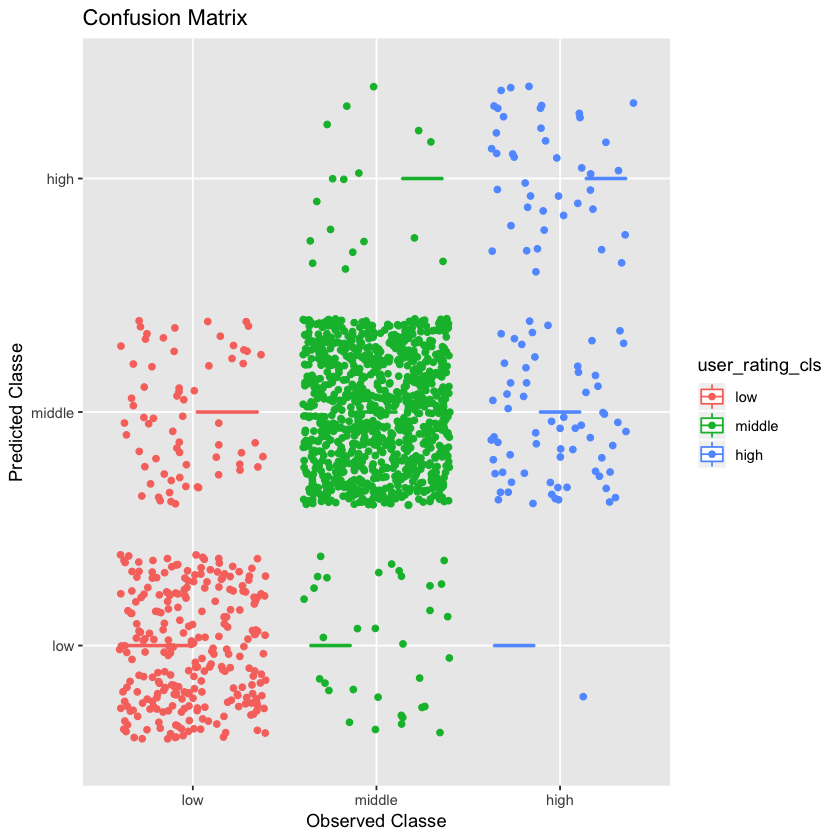

In [17]:
qplot(user_rating_cls, pred, data=quan_1_test,  colour=user_rating_cls,
      geom = c("boxplot", "jitter"), 
      main = "Confusion Matrix",
      xlab = "Observed Classe", ylab = "Predicted Classe")